In [1]:
from lambeq import BobcatParser, AtomicType, CircuitAnsatz, IQPAnsatz
from lambeq import Rewriter, remove_cups
from lambeq import Dataset, QuantumTrainer, SPSAOptimizer, NumpyModel, TketModel  
from lambeq.core.utils import flatten

from pytket.extensions.qiskit import tk_to_qiskit, AerBackend

import os
import warnings
import numpy as np
import functions
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
BATCH_SIZE = 30  ## batch size of training data if don't want to use full training dataset at once
EPOCHS = 400    ## number of epochs for training the model
SEED = 2

## Read the data file and extract sentence pairs and lablels

In [3]:
def read_data(filename):
    labels, sentence_pairs = [], []
    with open(filename) as f:
        for line in f:
            l = line.strip().split(',')
            labels.append(int(l[2]))  #, 1-int(l[2])]) ## using only one label per data
            sentence_pairs.append([l[0]]+ [l[1]])
            
    return labels, sentence_pairs

labels, sentence_pairs = read_data('datasets/MC1.txt')
train_labels, train_data = labels[:80], sentence_pairs[:80]  # for now first 60 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels[80:], sentence_pairs[80:]    # rest is test data

## Create a random dataset from the given data by shuffling to check the model yourself.

In [4]:
sentence_pairs1, labels1  = Dataset.shuffle_data(sentence_pairs, labels) ## returns data, target

train_labels, train_data = labels1[:80], sentence_pairs1[:80]  # for now first 80 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels1[80:], sentence_pairs1[80:]    # rest is test data

## Create sentence diagrams

In [5]:
parser = BobcatParser(verbose='suppress')  ## to select particular type of words like nouns use 'root_cats' parameter

raw_train_diagrams = [parser.sentences2diagrams(d) for d in train_data] # can send list of list of str to the function
#raw_dev_diagrams = [parser.sentences2diagrams(d) for d in dev_data]
raw_test_diagrams = [parser.sentences2diagrams(d) for d in test_data]

## Simplify and check for completed diagrams

In [6]:
## First filter out those diagrams which could not be parsed

## before filtering
#print(len(raw_train_diagrams), len(raw_dev_diagrams), len(raw_test_diagrams))

train_diagrams, train_labels_final = [], []
dev_diagrams, dev_labels_final = [], []
test_diagrams, test_labels_final = [], []

for diagram, label in zip(raw_train_diagrams, train_labels):
    if diagram[0] is not None and diagram[1] is not None:
        train_diagrams.append(remove_cups(diagram))
        train_labels_final.append(label)
        
# for diagram, label in zip(raw_dev_diagrams, dev_labels):
#     if diagram[0] is not None and diagram[1] is not None:
#         dev_diagrams.append(remove_cups(diagram))
#         dev_labels_final.append(label)

for diagram, label in zip(raw_test_diagrams, test_labels):
    if diagram[0] is not None and diagram[1] is not None:
        test_diagrams.append(remove_cups(diagram))
        test_labels_final.append(label)

print(len(train_diagrams), len(dev_diagrams), len(test_diagrams))

80 0 20


## Craete a different ansatz than the default IQPAnsatz from lambeq first by increasing the number of layers. We'll increase the layer upto 4 level and check the impact on the model using the same dataset.

## First check a single circuit to see whether cascade of layers have been implemented or not. 

Number of layers: 1


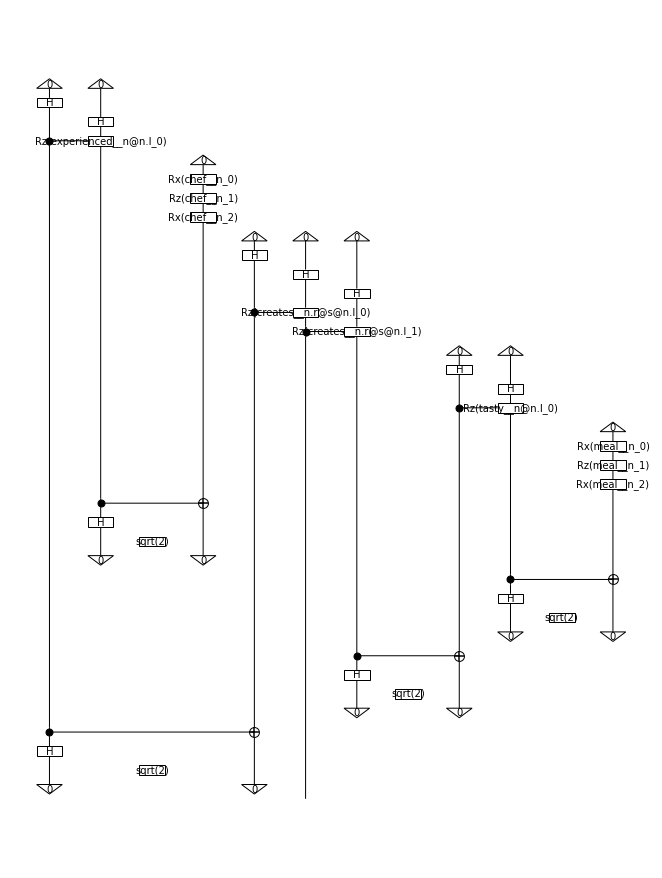

Number of layers: 2


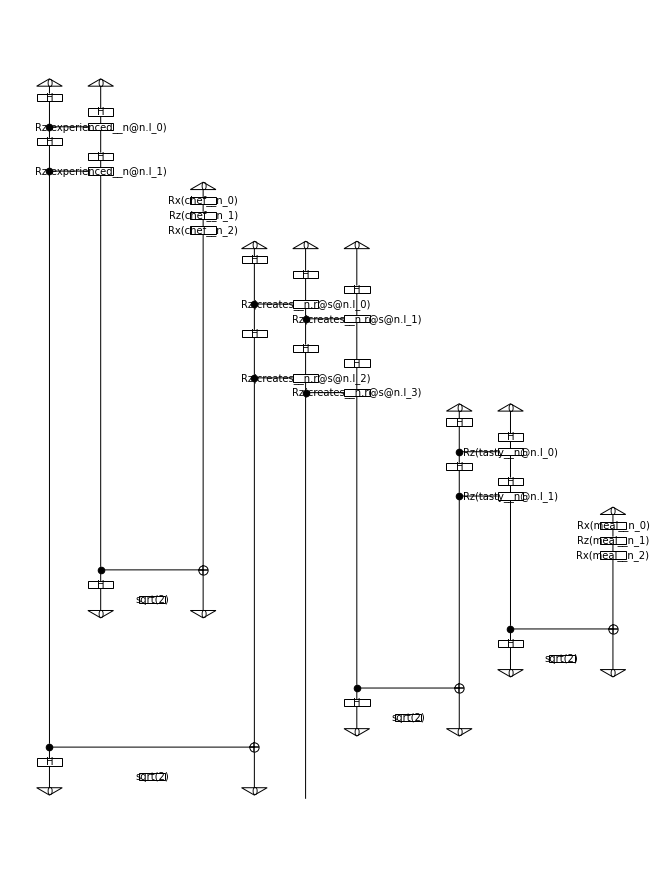

Number of layers: 3


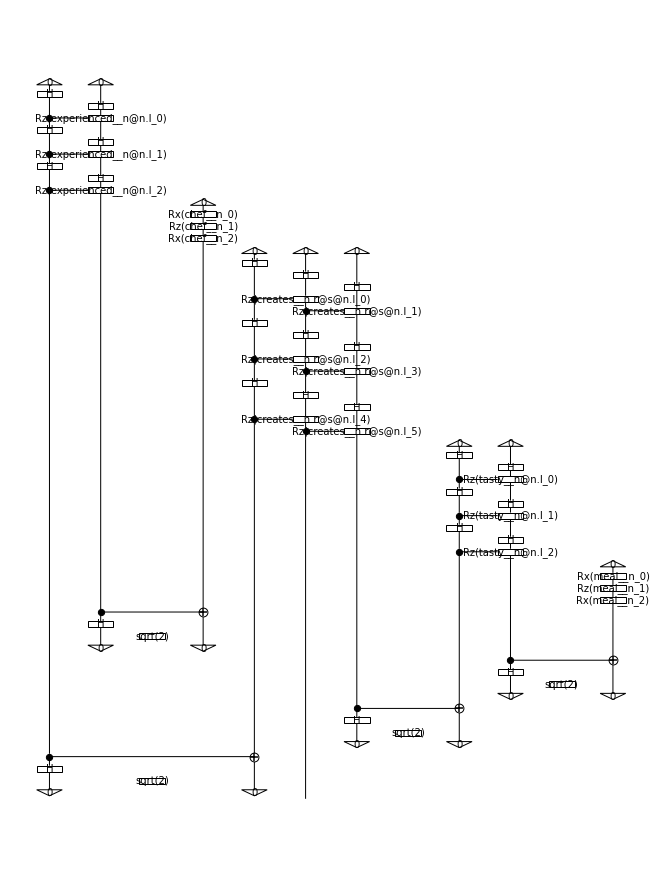

Number of layers: 4


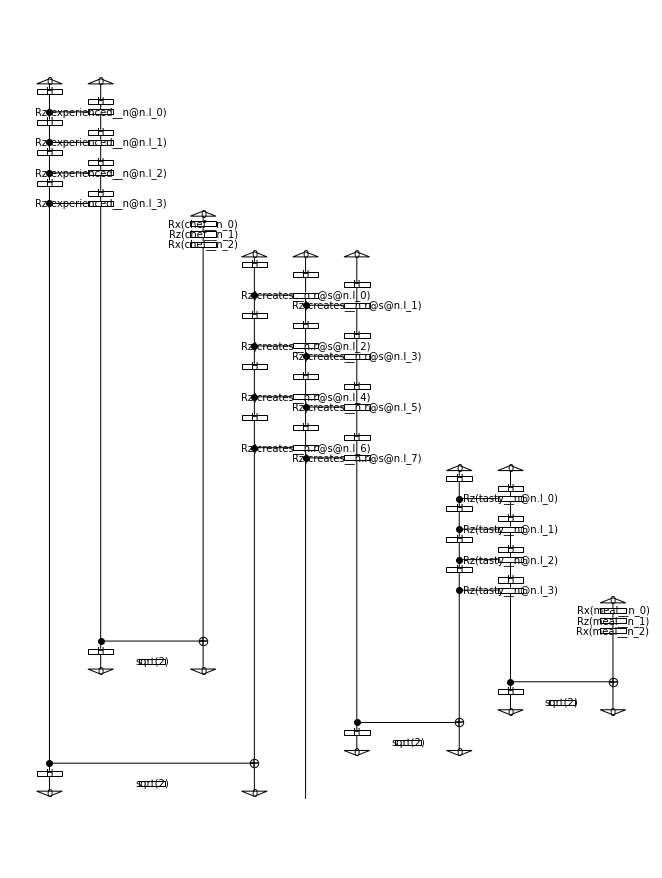

In [7]:
for i in range(1, 5):
    ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=i, n_single_qubit_params=3) 

    train_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in train_diagrams[:1]]
    test_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in test_diagrams[:1]]
    
    print('Number of layers: %d' %i)
    train_circuits[0][0].draw(figsize=(9, 12))

## Now actually implement different level of layers and check their effects.  The necessary loss and accuracy functions have been loaded from functions.py file.

training the model when number of circuit layers in ansatz is 1


Epoch 1:    train/loss: 0.4171   valid/loss: -----   train/acc: 0.4000   valid/acc: -----
Epoch 20:   train/loss: 0.3967   valid/loss: -----   train/acc: 0.5125   valid/acc: -----
Epoch 40:   train/loss: 0.3723   valid/loss: -----   train/acc: 0.5250   valid/acc: -----
Epoch 60:   train/loss: 0.3218   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 80:   train/loss: 0.2848   valid/loss: -----   train/acc: 0.7375   valid/acc: -----
Epoch 100:  train/loss: 0.2703   valid/loss: -----   train/acc: 0.7250   valid/acc: -----
Epoch 120:  train/loss: 0.2550   valid/loss: -----   train/acc: 0.7875   valid/acc: -----
Epoch 140:  train/loss: 0.2263   valid/loss: -----   train/acc: 0.8500   valid/acc: -----
Epoch 160:  train/loss: 0.2406   valid/loss: -----   train/acc: 0.8000   valid/acc: -----
Epoch 180:  train/loss: 0.2329   valid/loss: -----   train/acc: 0.8250   valid/acc: -----
Epoch 200:  train/loss: 0.1829   valid/loss: -----   train/acc: 0.9000   valid/acc: -----
Epoch 220:

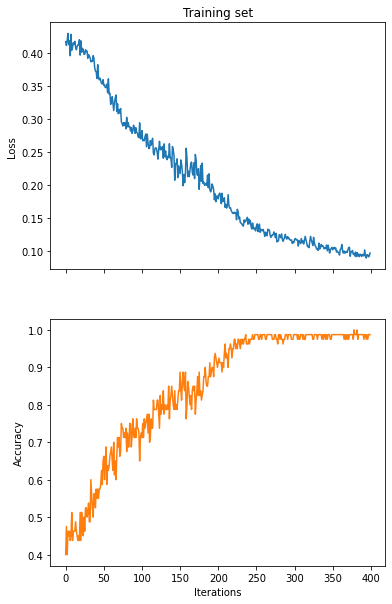

Test accuracy for n_layer 1: 1.000000
training the model when number of circuit layers in ansatz is 2


Epoch 1:    train/loss: 0.4340   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 20:   train/loss: 0.4359   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 40:   train/loss: 0.4193   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 60:   train/loss: 0.4123   valid/loss: -----   train/acc: 0.6125   valid/acc: -----
Epoch 80:   train/loss: 0.3993   valid/loss: -----   train/acc: 0.6500   valid/acc: -----
Epoch 100:  train/loss: 0.3976   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 120:  train/loss: 0.3967   valid/loss: -----   train/acc: 0.5625   valid/acc: -----
Epoch 140:  train/loss: 0.3965   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 160:  train/loss: 0.3866   valid/loss: -----   train/acc: 0.6500   valid/acc: -----
Epoch 180:  train/loss: 0.3785   valid/loss: -----   train/acc: 0.6375   valid/acc: -----
Epoch 200:  train/loss: 0.3824   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 220:

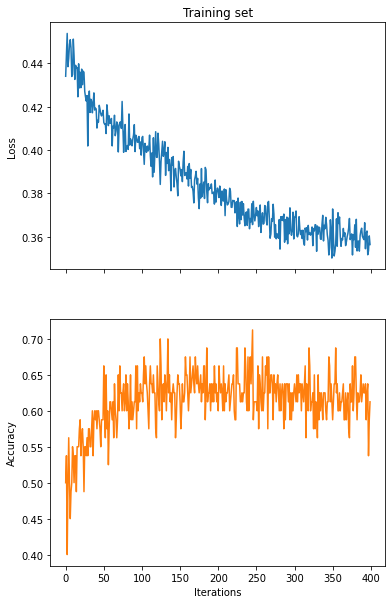

Test accuracy for n_layer 2: 0.650000
training the model when number of circuit layers in ansatz is 3


Epoch 1:    train/loss: 0.3485   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 20:   train/loss: 0.2181   valid/loss: -----   train/acc: 0.8500   valid/acc: -----
Epoch 40:   train/loss: 0.1606   valid/loss: -----   train/acc: 0.8375   valid/acc: -----
Epoch 60:   train/loss: 0.1388   valid/loss: -----   train/acc: 0.8750   valid/acc: -----
Epoch 80:   train/loss: 0.1353   valid/loss: -----   train/acc: 0.8625   valid/acc: -----
Epoch 100:  train/loss: 0.1246   valid/loss: -----   train/acc: 0.9125   valid/acc: -----
Epoch 120:  train/loss: 0.1079   valid/loss: -----   train/acc: 0.9375   valid/acc: -----
Epoch 140:  train/loss: 0.1065   valid/loss: -----   train/acc: 0.9250   valid/acc: -----
Epoch 160:  train/loss: 0.1002   valid/loss: -----   train/acc: 0.9125   valid/acc: -----
Epoch 180:  train/loss: 0.0917   valid/loss: -----   train/acc: 0.9250   valid/acc: -----
Epoch 200:  train/loss: 0.0997   valid/loss: -----   train/acc: 0.9375   valid/acc: -----
Epoch 220:

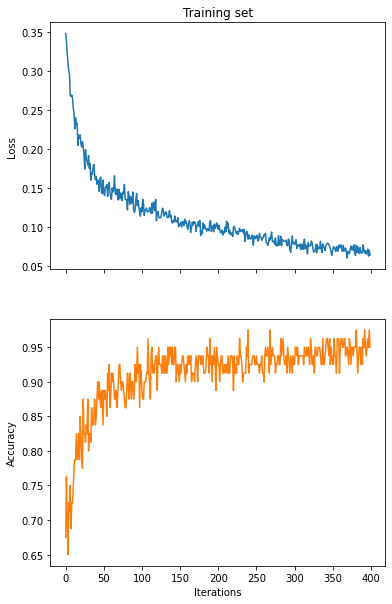

Test accuracy for n_layer 3: 1.000000
training the model when number of circuit layers in ansatz is 4


Epoch 1:    train/loss: 0.4219   valid/loss: -----   train/acc: 0.5375   valid/acc: -----
Epoch 20:   train/loss: 0.3844   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 40:   train/loss: 0.3524   valid/loss: -----   train/acc: 0.6625   valid/acc: -----
Epoch 60:   train/loss: 0.3524   valid/loss: -----   train/acc: 0.5625   valid/acc: -----
Epoch 80:   train/loss: 0.3439   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 100:  train/loss: 0.3387   valid/loss: -----   train/acc: 0.6500   valid/acc: -----
Epoch 120:  train/loss: 0.3347   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 140:  train/loss: 0.3402   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 160:  train/loss: 0.3286   valid/loss: -----   train/acc: 0.6625   valid/acc: -----
Epoch 180:  train/loss: 0.3178   valid/loss: -----   train/acc: 0.7000   valid/acc: -----
Epoch 200:  train/loss: 0.3199   valid/loss: -----   train/acc: 0.7125   valid/acc: -----
Epoch 220:

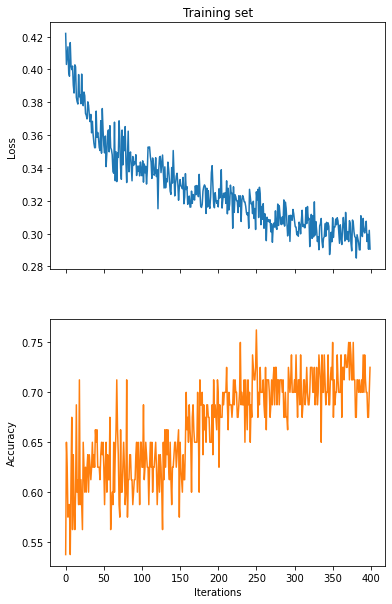

Test accuracy for n_layer 4: 0.250000
training the model when number of circuit layers in ansatz is 5


Epoch 1:    train/loss: 0.3872   valid/loss: -----   train/acc: 0.5125   valid/acc: -----
Epoch 20:   train/loss: 0.3599   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 40:   train/loss: 0.3549   valid/loss: -----   train/acc: 0.6500   valid/acc: -----
Epoch 60:   train/loss: 0.3612   valid/loss: -----   train/acc: 0.5625   valid/acc: -----
Epoch 80:   train/loss: 0.3446   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 100:  train/loss: 0.3359   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 120:  train/loss: 0.3302   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 140:  train/loss: 0.3141   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 160:  train/loss: 0.3279   valid/loss: -----   train/acc: 0.5750   valid/acc: -----
Epoch 180:  train/loss: 0.3331   valid/loss: -----   train/acc: 0.5750   valid/acc: -----
Epoch 200:  train/loss: 0.3170   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 220:

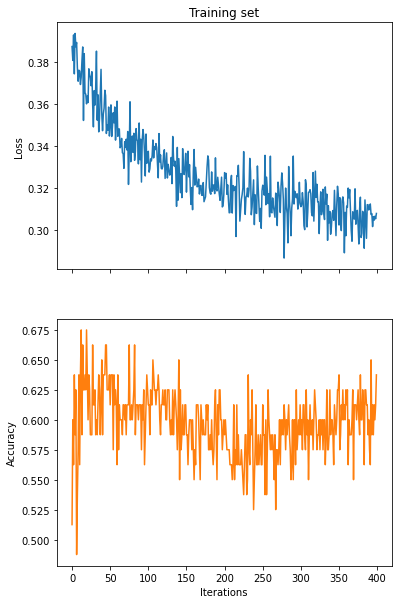

Test accuracy for n_layer 5: 0.450000


In [8]:
for i in range(1, 6):
    ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=i, n_single_qubit_params=3) 

    train_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in train_diagrams]
    test_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in test_diagrams]
    
    
    all_circuits = [d for d in flatten(train_circuits)] + [d for d in flatten(test_circuits)]
    model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
    
    trainer = QuantumTrainer(
    model,
    loss_function=functions.loss_func_1,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': functions.accuracy_func_1},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
    )
    
    train_dataset = Dataset([d for d in flatten(train_circuits)], np.repeat(train_labels, 2, axis=0),  batch_size=BATCH_SIZE*2, shuffle=False)
    
    print('training the model when number of circuit layers in ansatz is %d' %i)
    
    trainer.fit(train_dataset, logging_step=20)
    
    fig, (ax_t, ax_b) = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(6, 10))
    ax_t.set_title('Training set')
    ax_b.set_xlabel('Iterations')
    ax_b.set_ylabel('Accuracy')
    ax_t.set_ylabel('Loss')

    colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    ax_t.plot(trainer.train_epoch_costs, color=next(colours))
    ax_b.plot(trainer.train_results['acc'], color=next(colours))
    plt.show()

    test_acc = functions.accuracy_func_1(model([d for d in flatten(test_circuits)]), np.repeat(test_labels, 2, axis=0))
    print('Test accuracy for n_layer %d: %f'  %(i, test_acc))

## I would expect the model to train faster and the accuracy to be better with increased layer of gates. However, it doesn't seems to be the case.